## Overview

This notebook introduces you to Support Vector Machines, it consists of the following three parts:

1. <a href=#Part-1:-The-SVM-Problem>The SVM Problem</a>
2. <a href=#Part-2:-Kernels>Kernels</a>
3. <a href=#(Optional)-Part-3:-$\nu$-SVM-and-Multiclass-SVM>(Optional) $\nu$-SVM and Multiclass SVM</a>
5. <a href=#(Optional)-Part-4:-Scikit-Learn-Implementation>(Optional) Sckit-Learn Implementation</a>

### Programming Tasks
For the programming tasks you will need to replace the following comment and exception with your own code:

```python
# YOUR CODE HERE
raise NotImplementedError()
```

Most programming tasks are followed by a cell with tests (using the `assert` keyword from python). You can consult these cells while developing your implementation and for validation. Note that there may be additional, hidden tests.

**<font size="3" color="red">Note</font>**: The `@contract` decorators make sure the data types and shapes are correct for the inputs and outputs. See [here](https://andreacensi.github.io/contracts/tour.html#quick-tour) for more. If you are more comfortable working without these, you can comment out the lines starting with `@contract`. However, in that case it can get tedious to locate the exact source of a bug.

### Open Questions
The notebook also contains a few open questions. You don't get points for the open questions, they are here to improve your understanding of the topic. For the open questions you can put your answer in the cell below the question, replace the text "YOUR ANSWER HERE" with your own answer. You can later check your answer with the answer given in the solution version of the notebook.

In [1]:
# DO NOT INSTALL THE LIBRARIES WHEN WORKING ON ifi-europa.uibk.ac.at

# Make sure that the required libraries are installed
# If you are using Google Colab, remember to upload the requirements file before 
# running this cell
# If you are running this notebook locally, the requirements file needs to be in 
# the same location as this notebook
import os
running_local = True if os.getenv('JUPYTERHUB_USER') is None else False
    
if running_local:
    import sys
    !{sys.executable} -m pip install -r requirements_week05.txt

In [2]:
%config InlineBackend.figure_formats = ['svg']

from collections import namedtuple
from contracts import contract
import numpy as np
import cvxopt
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.datasets import make_blobs, make_circles, make_moons
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
%matplotlib inline

In [3]:
# Counter for figures
figcount = 0

# Set the random seed for reproducing results
random_seed = 97 
np.random.seed(random_seed)

# Colors to use for plotting
colors = [plt.cm.Paired(3), plt.cm.Paired(1), plt.cm.Paired(5)]

# Data set namedtuple
DataSet = namedtuple("DataSet", ("X_train", "X_test", "y_train", "y_test"))

<a href=#Overview> [go to top] </a>
# Part 1: The SVM Problem

### SVM Optimization Problem
Remember from the VO that the SVM optimization problem is defined as follows: 

$$
\underset{\mathbf{w}, b}{\arg \min} \frac{1}{2}\|\mathbf{w}\|^2
$$

$$
\text{subject to}\quad\quad y_i(\mathbf{w}^T\phi\left(\mathbf{x}_i) + b\right) \geq 1,\quad i = 1, \ldots, N
$$

where

- $\mathbf{w}$ are the weights of our linear model
- $b$ is the bias term of our linear model
- $\mathbf{x}_i$ is the i-th input sample
- $y_i$ is i-th target, with a value of $-1$ or $1$

### Lagrange Multipliers
We can solve the optimization problem above by introducing *lagrange multipliers* $a_i$ for $i = 1, \ldots, N$ and maximizing the *Lagrangean* $L$:

$$L(\mathbf{w}, b, \mathbf{a}) = \frac{1}{2}\|\mathbf{w}\|^2 - \sum_{i=1}^N a_n\left[y_i(\mathbf{w}^T\phi(\mathbf{x}_i) + b) - 1\right]$$

We can derive two conditions by taking the derivative w.r.t. $\mathbf{w}$ and $b$ and setting it to zero:

$$\frac{\partial L}{\partial \mathbf{w}} = \mathbf{w} - \sum_{i=1}^N a_i y_i\phi(\mathbf{x}_i) = 0 \quad \longrightarrow \quad \mathbf{w} = \sum_{i=1}^N a_i y_i\phi(\mathbf{x}_i)$$

$$\frac{\partial L}{\partial b} = -\sum_{i=1}^N a_i y_i = 0 \quad \longrightarrow \quad \sum_{i=1}^N a_i y_i = 0$$

Substituting both conditions back into $L$ gives us the following *Lagrangean* to maximize:

$$\tilde{L}(\mathbf{a}) = \sum_{i=1}^N a_i - \frac{1}{2} \sum_{i=1}^N \sum_{j=1}^N a_i a_j y_i y_j \phi(\mathbf{x}_i) \cdot \phi(\mathbf{x}_j)$$

The optimization problem is:

$$
\underset{\mathbf{a}}{\arg\max}\ \tilde{L}(\mathbf{a}) = \underset{\mathbf{a}}{\arg\max}\ \sum_{i=1}^N a_i - \frac{1}{2} \sum_{i=1}^N \sum_{j=1}^N a_i a_j y_i y_j \phi(\mathbf{x}_i) \cdot \phi(\mathbf{x}_j) 
$$
$$
\begin{split}
\text{subject to}\quad\quad\quad a_i &\geq 0,\quad i = 1, \ldots, N\\
\sum_{i=1}^N a_iy_n &= 0
\end{split}
$$

### Matrix form
We can rewrite the problem above into matrix form. The accompanying [qp_notation_svm.pdf](qp_notation_svm.pdf) shows how to rewrite the formulation given above into matrix form. The optimization problem in matrix form is:

$$\underset{\mathbf{a}}{\arg \max}\ \tilde{L}(\mathbf{a}) = \underset{\mathbf{a}}{\arg\max}\ \mathbb{1}_N^T\mathbf{a} - \frac{1}{2}\mathbf{a}^T\mathbf{P}\mathbf{a}$$
$$
\begin{split}
\text{subject to}\quad\quad a_i &\geq 0, \quad i=1,\ldots,N \\
\mathbf{y}^T \mathbf{a} &= 0
\end{split}
$$

with 

- $\mathbb{1}_N = [1, 1, \ldots 1]^T \in \mathbb{N}^{N}$
- $\mathbf{P} = (\mathbf{y}\mathbf{y}^T) \circ \mathbf{K}$, where $(\mathbf{y}\mathbf{y}^T)$ is the [*outer product*](https://en.wikipedia.org/wiki/Outer_product) and $\circ$ is the [*Hadamard product*](https://en.wikipedia.org/wiki/Hadamard_product_(matrices)), also known as element wise matrix multiplication.
- $\mathbf{K}$ is the *Gram matrix*. 

First we are going to look at a binary classification problem in which the data is linearly separable in the input space $\mathbf{x}$ and where the dataset contains just four points. Most steps for this simple problem can be validated by hand, we highly recommend you do that.

The functions in part 1 will be used throughout the notebook.

In order to solve the SVM problem we are going to complete the following steps:
1. Define the linear kernel and compute the Gram matrix $\mathbf{K}$
2. Compute Matrix $\mathbf{P}$
3. Solve the optmization problem to find $\mathbf{a}$
4. Compute the support vectors
5. Compute $\mathbf{w}$
6. Compute $b$
7. Define the decision function $f$ and a predictor for $y$

In [4]:
def get_test_data_set():
    X_train = np.array([[1, 1],
                        [2, 2],
                        [3, 3],
                        [4, 4]])
    
    y_train = np.array([-1, -1, 1, 1]) # For SVM we need target values {-1,+1} 
    X_test = np.array([[1.2, 2.3],
                       [2.5, 1.7],
                       [2.7, 3.2],
                       [3.5, 2.5]])
    y_test = np.array([-1, -1, 1, 1])
    
    return DataSet(X_train, X_test, y_train, y_test)

def plot_data(ax, data_set, legend='upper left'):
    X_train, X_test, y_train, y_test = data_set
    
    # Scatter plotting the data, filtering them according the pos/neg values
    for y in [-1, 1]:        
        ax.scatter(X_train[y_train == y, 0], X_train[y_train == y, 1], 
                   c=[colors[y]], 
                   s=30, 
                   label=r'$y={}$ (train)'.format(y))
        ax.scatter(X_test[y_test  == y, 0], X_test[y_test  == y, 1], 
                   c=[colors[y]], 
                   s=50, 
                   marker='x', 
                   label=r'$y={}$ (test)'.format(y))
    
    # Set Labels and Limits
    ax.set_xlabel(r'$x_0$')
    ax.set_ylabel(r'$x_1$')
    ax.set_xlim(min(X_train[:, 0].min(), X_test[:,0].min()) - 0.1, 
                max(X_train[:, 0].max(), X_test[:,0].max()) + 0.1)
    ax.set_ylim(min(X_train[:, 1].min(), X_test[:,1].min()) - 0.1, 
                max(X_train[:, 1].max(), X_test[:,1].max()) + 0.1)
    
    # Legend
    if legend is not None:
        pst = ax.legend(loc=legend, frameon=True)
        pst.get_frame().set_edgecolor('k')

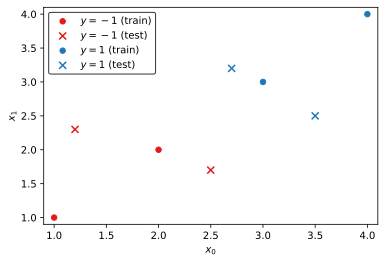

In [5]:
# Get data set
test_data_set = get_test_data_set()

# Plot data
plt.figure()
ax = plt.gca()
plot_data(ax, test_data_set)

## Linear Kernel
It is clear that the data is linearly separable in the input space $\mathbf{x}$. Therefore we do not need to transform our data using some feature mapping, i.e., we can use the linear feature $\phi(\mathbf{x}) = \mathbf{x}$. The *linear kernel* is the kernel associated with $\phi(\mathbf{x}) = \mathbf{x}$. The first task is to derive the linear kernel and write a function that computes it.

Later on we will need to calculate the kernel between two sets of datapoints, e.g., the Gram matrix. Write the `linear_kernel` function below in such a way it can compute the kernel between two vectors and between two matrices:

- For two data points $\mathbf{x}_1 = [1, 1, 1]$ and $\mathbf{x}_2 = [2, 2, 2]$ the kernel is 
$$k(\mathbf{x}_1, \mathbf{x}_2) = \phi(\mathbf{x}_1)^T\phi(\mathbf{x}_2)$$
- For two data sets $\mathbf{X}_1 = [\mathbf{x}_{11}, \mathbf{x}_{12}, \mathbf{x}_{13}]^T$ and $\mathbf{X}_2 = [\mathbf{x}_{21}, \mathbf{x}_{22}]^T$ the kernel is 
$$k(\mathbf{X}_1, \mathbf{X}_2) = \left[\begin{array}{cc}
    k(\mathbf{x}_{11}, \mathbf{x}_{12}) & k(\mathbf{x}_{11}, \mathbf{x}_{22}) \\
    k(\mathbf{x}_{12}, \mathbf{x}_{12}) & k(\mathbf{x}_{12}, \mathbf{x}_{22}) \\
    k(\mathbf{x}_{13}, \mathbf{x}_{12}) & k(\mathbf{x}_{13}, \mathbf{x}_{22}) \\
\end{array}\right]$$ 

Note that the two matrices do not need to contain the same number of datapoints, but the datapoints do need to be of the same dimension. Furthermore note that $k(\mathbf{X}_1, \mathbf{X}_1)$ is the Gram matrix.

In [6]:
@contract(x_i='array[M] | array[NxM]',
          x_j='array[M] | array[KxM]',
          returns='number | array[NxK] ')
def linear_kernel(x_i, x_j):
    """
    Compute the linear kernel between two arrays of data.
    
    NOTE: x_i and x_j can be both one-dimensional arrays or 
          both two-dimensional arrays.
         
    TIP: Try to avoid using any loops, use numpy methods instead.
    
    :param x_i: first input array
    :param x_j: second input array
    :returns:   linear kernel
    """
    assert x_i.ndim == x_j.ndim, f"Kernel only accepts two inputs with the same number of dimensions.\n\
    \t x_i.ndim = {x_i.ndim}\n\
    \t x_j.ndim = {x_j.ndim}"
    
  
    k = x_i@ np.transpose(x_j)

    
    return k

@contract(x='array[M] | array[NxM]',
          returns='array[M] | array[NxM]')
def linear_feature(x):
    """
    Returns the feature associated with the linear kernel:
    
      phi(x) = x
    
    :param x: input array
    :returns: feature
    """
    return x

In [7]:
# Test with vectors
x_i = np.array([1, 2, 3])
x_j = np.array([1, 1, 1])

assert linear_kernel(x_i, x_i) == 14
assert linear_kernel(x_i, x_j) == 6
assert linear_kernel(x_j, x_j) == 3

# Test with matrices
X_i = np.array([[1, 1, 1], [2, 2, 2], [3, 3, 3]])
X_j = np.array([[1, 2, 3], [2, 3, 4]])

assert np.allclose(linear_kernel(X_i, X_j), np.array([[6, 9], [12, 18], [18, 27]]))
assert np.allclose(linear_kernel(X_i, X_i), np.array([[3, 6, 9], [6, 12, 18], [9, 18, 27]]))

# Test Gram matrix on test_data_set
K_true = np.asarray([[2,  4,  6,  8],
                     [4,  8, 12, 16],
                     [6, 12, 18, 24],
                     [8, 16, 24, 32]])

K = linear_kernel(test_data_set.X_train, test_data_set.X_train)
print("K:")
print(K)

assert np.allclose(K, K_true)

K:
[[ 2  4  6  8]
 [ 4  8 12 16]
 [ 6 12 18 24]
 [ 8 16 24 32]]


## Matrix P
Now that we have our kernel and Gram matrix we can start defining the other variables for our optimization problem. One of the variables we need is the matrix $\mathbf{P} = (\mathbf{y}\mathbf{y}^T) \circ \mathbf{K}$.

In [8]:
@contract(K='array[NxN]',
          y='array[N]',
          returns='array[NxN]')
def compute_P(K, y):
    """
    Compute matrix P.
    
    :param K: Gram matrix
    :param y: target values
    :returns: matrix P
    """

    # use np functions
    yy = np.outer(y,np.transpose(y))
    P = np.multiply(yy,K) #hadamard product
    

    return P

In [9]:
P_true = np.asarray([[ 2,   4,  -6,  -8],
                     [ 4,   8, -12, -16],
                     [-6, -12,  18,  24],
                     [-8, -16,  24,  32]])

P = compute_P(K, test_data_set.y_train)
print("P:")
print(P)

assert np.allclose(P, P_true)

P:
[[  2   4  -6  -8]
 [  4   8 -12 -16]
 [ -6 -12  18  24]
 [ -8 -16  24  32]]


## Solving the Optimization
Now it is time to solve the SVM optimization problem using the functions you have defined above. Remember that the optimization problem is:

$$\underset{\mathbf{a}}{\text{maximize}}\ \mathbb{1}_N^T\mathbf{a} - \frac{1}{2}\mathbf{a}^T\mathbf{P}\mathbf{a}$$
$$
\begin{split}
\text{subject to}\quad\quad a_i &\geq 0, \quad i=1,\ldots,N \\
\mathbf{y}^T \mathbf{a} &= 0
\end{split}
$$

We don't want you to be spending too much time on having to figure out the `cvxopt` library, therefore the `optimize_svm` function is given. Go through the code to validate for yourself what is happening and what each function means. Also have a look at the [cvxopt](https://cvxopt.org) documentation or use the build in documentation viewer (e.g., `cvxopt.solvers.qp?`).

In [10]:
@contract(X='array[NxM]',
          y='array[N]',
          returns='array[N]')
def optimize_svm(X, y, kernel=linear_kernel):
    """
    Solves the the quadratic programming problem.
    
    The optimization does not always succeed, this can
    have several causes. 
    
    When you get the error that the problem is not DCP 
    we recommend trying different hyperparameters or a 
    different kernel. Often the reason for this problem
    is that the data is not linearly separable in the 
    feature space.
    
    Another error that can occur is that the solver
    was not able to find a solution. In this case, run
    the optimization again. Sometimes it was just some
    initialization error within the solver. If the solver
    keeps failing to solve the problem you have to change
    the hyperparameters or kernel.
    
    The main reason for problems however is wrongly 
    implemented methods. So step one should always be,
    check your implementation.
    
    :param X:      training values
    :param y:      target values
    :param kernel: kernel function (function or callable object)
    :returns:      Lagrangian multipliers
                   None if optimization fails
    """
    N = y.shape[0]
    
    K = kernel(X, X)
    P = compute_P(K, y)
    P = 0.5 * (P + P.T) # make sure P is symmetric, increases stability of optimization
    
    K = cvxopt.matrix(K)
    P = cvxopt.matrix(P)
    q = cvxopt.matrix(-1.0 * np.ones(N))
    
    # Equality constraints
    A = cvxopt.matrix(y.astype('float'), (1, N))
    b = cvxopt.matrix(0.0)
    
    # Inequality constraints
    G = cvxopt.matrix(np.diag(-1.0 * np.ones(N)))
    h = cvxopt.matrix(np.zeros(N).astype('float'))
        
    # Solve the quadratic programming problem
    solution = cvxopt.solvers.qp(P, q, G, h, A, b)
    
    if 'optimal' not in solution['status']:
        print("No solution could be found, is the data linearly separable in the feature space?")
        return None
    
    # Lagrangian multipliers
    return np.ravel(solution['x'])

In [11]:
a = optimize_svm(test_data_set.X_train, test_data_set.y_train, linear_kernel)
print("\na:", a)

assert np.allclose(a, [0, 1, 1, 0])

     pcost       dcost       gap    pres   dres
 0: -9.5868e-01 -1.9174e+00  7e+00  2e+00  2e+00
 1: -1.4398e+00 -1.5363e+00  7e-01  2e-01  2e-01
 2: -9.9503e-01 -1.0507e+00  6e-02  3e-16  4e-15
 3: -9.9995e-01 -1.0005e+00  5e-04  3e-16  2e-15
 4: -1.0000e+00 -1.0000e+00  5e-06  5e-17  2e-15
 5: -1.0000e+00 -1.0000e+00  5e-08  3e-16  2e-15
Optimal solution found.

a: [1.21694401e-09 1.00000002e+00 1.00000002e+00 1.21694401e-09]


## Computing the Support Vectors

##### Note on Numerical Values:
Since we are working with numerical optimization, results
will have small errors and cannot be compared directly. We 
can work around this problem by using small thresholds. 

For example:
We have a true value `y = 0` and some numerical optimization 
calculates an estimate `yhat = 0.0000001` for `y`. Comparing 
using `y == yhat` gives back `False`. Instead we can use
`yhat < threshold` to circumvent the problem.

In [38]:
@contract(a='array[N]',
          threshold='float',
          returns='array[S]')
def compute_svi(a, threshold=1e-5):
    """
    Compute the indices of the support vectors.
    
    TIP: Remember that support vectors correspond to 
         indices that have a lagrange multiplier > 0.
         
    TIP: Try to avoid using any loops, use numpy methods instead.
    
    :param a:         Lagrange multipliers
    :param threshold: threshold value
    :returns:         indices of the support vectors
    """
    
    svi = a+threshold
    
    return svi

In [39]:
a = optimize_svm(test_data_set.X_train, test_data_set.y_train, linear_kernel)
print("a:", a)

svi = compute_svi(a)
print("\nsvi:", svi)

support_vectors = test_data_set.X_train[svi]
print("support vectors:")
print(support_vectors)

assert np.allclose(svi, [1, 2])

     pcost       dcost       gap    pres   dres
 0: -9.5868e-01 -1.9174e+00  7e+00  2e+00  2e+00
 1: -1.4398e+00 -1.5363e+00  7e-01  2e-01  2e-01
 2: -9.9503e-01 -1.0507e+00  6e-02  3e-16  4e-15
 3: -9.9995e-01 -1.0005e+00  5e-04  3e-16  2e-15
 4: -1.0000e+00 -1.0000e+00  5e-06  5e-17  2e-15
 5: -1.0000e+00 -1.0000e+00  5e-08  3e-16  2e-15
Optimal solution found.
a: [1.21694401e-09 1.00000002e+00 1.00000002e+00 1.21694401e-09]

svi: [1.00012169e-05 1.00001002e+00 1.00001002e+00 1.00012169e-05]


IndexError: arrays used as indices must be of integer (or boolean) type

### Question 1: what do support vectors represent?
The SVM tries to find a decision boundary that separates two classes with the widest margin. For points on the decision boundary we know that the decision function equals zero:

$$f(\mathbf{x}) = \mathbf{w}^T\phi(\mathbf{x}) + b = 0$$

What is the value of the decision function for the support vectors?

YOUR ANSWER HERE

## Computing $\mathbf{w}$ 

We can compute $\mathbf{w}$ using the following equation:

$$\mathbf{w} = \sum_{i=1}^N a_i y_i\phi(\mathbf{x}_i)$$


Note: for the computation of $\mathbf{w}$ we require the feature mapping $\phi$. But we do not actually need the feature mapping $\phi$ for solving the SVM problem, i.e., we don't need to compute the actual values for $\mathbf{w}$ to solve the SVM problem. This will become clear later on in the notebook.

In [61]:
@contract(a='array[N]',
          y='array[N]',
          X='array[NxM]',
          returns='array[M]')
def compute_w(a, y, X, feature=linear_feature):
    """
    Compute weight vector w for the linear kernel
    
    TIP: Try to avoid using any loops, use numpy methods instead.
    
    :param a:       Lagrange multipliers
    :param y:       target values
    :param x:       training vectors
    :param feature: feature mapping (function or callable object)
    :returns:       weights
    """
    
    w = a*y@X
    
    return w

In [62]:
a = optimize_svm(test_data_set.X_train, test_data_set.y_train, linear_kernel)
print("a:", a)

w = compute_w(a, test_data_set.y_train, test_data_set.X_train)
print("\nw:", w)

assert np.allclose(w, [1, 1])

     pcost       dcost       gap    pres   dres
 0: -9.5868e-01 -1.9174e+00  7e+00  2e+00  2e+00
 1: -1.4398e+00 -1.5363e+00  7e-01  2e-01  2e-01
 2: -9.9503e-01 -1.0507e+00  6e-02  3e-16  4e-15
 3: -9.9995e-01 -1.0005e+00  5e-04  3e-16  2e-15
 4: -1.0000e+00 -1.0000e+00  5e-06  5e-17  2e-15
 5: -1.0000e+00 -1.0000e+00  5e-08  3e-16  2e-15
Optimal solution found.
a: [1.21694401e-09 1.00000002e+00 1.00000002e+00 1.21694401e-09]

w: [1.00000003 1.00000003]


## Computing $b$
The decision function is defined as:

$$f(\mathbf{x}) = \mathbf{w}^T\phi(\mathbf{x}) + b$$

for the support vectors $\mathbf{x}_s \in \mathcal{S}$, where $\mathcal{S}$ denotes the set of all support vectors, we know that: 

$$f(\mathbf{x_s}) = \mathbf{w}^T\phi(\mathbf{x_s}) + b = y_s$$ 

the values for $\mathbf{w}$ and $\mathbf{x}_s$ are known, so we can solve for $b$:

$$b = y_s - \mathbf{w}^T\phi(\mathbf{x_s})$$

But which support vector $\mathbf{x}_s$ do we use? It turns out that just using one value might result in stability issues. A commonly used solution is to average over all support vectors $\mathcal{S}$:

$$b = \frac{1}{|\mathcal{S}|}\sum_{i \in \mathcal{S}}y_i - \mathbf{w}^T\phi(\mathbf{x}_i)$$

One more issue remains, our expression for $b$ contains the feature $\phi(\mathbf{x}_i)$. One nice property of SVMs is that the feature mapping $\phi$ does not have to be known, but only a kernel $k(\mathbf{x}_i, \mathbf{x}_j)$ that is valid for $\phi$.

### Question 2: What is an advantage of using $k$ instead of $\phi$?
Remember that a kernel function is defined as $k(\mathbf{x}_i, \mathbf{x}_j) = \phi(\mathbf{x}_i)^T\phi(\mathbf{x}_j)$. Tip: how does the feature mapping $\phi$ of, for example, $k(\mathbf{x}_i, \mathbf{x}_j) = (\mathbf{x}_i^T\mathbf{x}_j)^2$ look?

YOUR ANSWER HERE

Rewrite the expression for $b$ into a form that uses the kernel function $k(\mathbf{x}_i, \mathbf{x}_j)$ instead of $\phi(\mathbf{x}_i)$. Substitute the expression for $\mathbf{w}$ into the equation for $b$. Use the rewritten expression in the tasks below.

In [ ]:
@contract(a_sv='array[S]',
          y_sv='array[S]',
          support_vectors='array[SxM]',
          returns='number')
def compute_b(a_sv, y_sv, support_vectors, kernel=linear_kernel):
    """
    Compute the bias variable `b` using the averaging approach.
    
    TIP: Try to avoid using any loops, use numpy methods instead.
    
    :param a_sv:            lagrange multipliers corresponding to the support vectors 
    :param y_sv:            target values corresponding to the support vectors
    :param support_vectors: support vectors
    :param kernel:          kernel
    :returns:               bias variable
    """

    # YOUR CODE HERE (please remove 'raise NotImplementedError()')
    raise NotImplementedError()
    return b

For a linear kernel the feature mapping is particularly easy: $\phi(\mathbf{x}) = \mathbf{x}$. We will use this for evaluating the function `compute_b` by comparing the results with the expression:

$$b = \frac{1}{|\mathcal{S}|}\sum_{i \in \mathcal{S}}y_i - \mathbf{w}^T\phi(\mathbf{x}_i)$$

Solve this exercise by hand an add the solution in the cell below:

In [ ]:
@contract(returns='number')
def b_features():
    """
    Return the value you found by solving the equation above.
    
    Compute the value for b by hand and assign it to variable b:
    
        b = REPLACE_WITH_YOUR_VALUE_FOR_B
    
    :returns: bias b
    """
    
    # YOUR CODE HERE (please remove 'raise NotImplementedError()')
    raise NotImplementedError()
    
    return b

In [ ]:
a = optimize_svm(test_data_set.X_train, test_data_set.y_train, linear_kernel)
print("a:", a)

svi = compute_svi(a)
print("svi:", svi)

# Support vectors
support_vectors = test_data_set.X_train[svi]
a_sv = a[svi]
y_sv = test_data_set.y_train[svi]

# Disable linear_feature function for testing
_linear_feature = linear_feature
try:
    def linear_feature(x):
        raise AssertionError("Your `compute_b` function uses the `linear_feature` function which is not allowed.")
        
    b = compute_b(a_sv, y_sv, support_vectors, linear_kernel)
except AssertionError as e:
    raise e
finally:
    linear_feature = _linear_feature
    
# Print result and test
print("\nb:", b)
assert abs(b - b_features()) < 1e-5

## Decision Function and Prediction 
We now have all the components for our model, the next step is to use them for making predictions. We split the prediction into two parts, first part is the decision function $f$. The predictor can use the decision function for making predictions. We will also define an accuracy metric for evaluating the accuracy of our model on a test set.

Your implementation for the `decision_function` and `predict` should use the kernel function $k(\mathbf{x}_i, \mathbf{x}_j)$ and not $\phi(\mathbf{x}_i)$. Substitute the expression for $\mathbf{w}$ into the decision function $f(\mathbf{x})$ and rewrite such that $\phi$ disappears (like you did for the expression for $b$).

In [ ]:
@contract(X_pred='array[KxM]',
          a='array[N]',
          y_train='array[N]',
          X_train='array[NxM]',
          b='number',
          returns='array[K]')
def decision_function(X_pred, a, y_train, X_train, b, kernel=linear_kernel):
    """
    The decision function tells us on which side of the decision boundary 
    generated by `f` a set of samples `X_pred` is located
    
    TIP: Try to avoid using any loops, use numpy methods instead.
    
    :param X_pred:  input samples to predict the decision function for
    :param a:       lagrange multipliers
    :param y_train: target samples from the training set 
    :param X_train: input samples from the training set
    :param b:       bias variable
    :param kernel:  kernel (function or callable object)
    :returns:       decision function value
    """
    
    # YOUR CODE HERE (please remove 'raise NotImplementedError()')
    raise NotImplementedError()
    
    return f
    
@contract(X_pred='array[KxM]',
          a='array[N]',
          y_train='array[N]',
          X_train='array[NxM]',
          b='number',
          returns='array[K]')   
def predict(X_pred, a, y_train, X_train, b, kernel=linear_kernel):
    """
    Predicts the target value for a set of samples `X_pred`
    
    For each sample `x` in `X_pred` the target value must be `y=1` or `y=-1`.
    
    Tip: use the decision function defined above.
    
    :param X_pred:  input samples to predict the decision function for
    :param a:       lagrange multipliers
    :param y_train: target samples from the training set 
    :param X_train: input samples from the training set
    :param b:       bias variable
    :param kernel: kernel (function or callable object)
    :returns:      prediction yhat={-1, 1} 
    """
    
    # YOUR CODE HERE (please remove 'raise NotImplementedError()')
    raise NotImplementedError()
    
    return yhat

@contract(y='array[N]',
          yhat='array[N]',
          returns='number')
def accuracy(y, yhat):
    """
    Calculates the accuracy as the number of correctly predicted
    target divided by the total number of predictions.
        
    :param y:    actual target values
    :param yhat: predicted target values
    :returns:    accuracy score
    """
    
    # YOUR CODE HERE (please remove 'raise NotImplementedError()')
    raise NotImplementedError()
    
    return score

In [ ]:
X_train, X_test, y_train, y_test = test_data_set
f_test = np.asarray([-1.5, -0.8, 0.9, 1.])

# Optimize
a = optimize_svm(test_data_set.X_train, test_data_set.y_train, linear_kernel)
print("a:", a)

# Extract support vectors
svi = compute_svi(a)
print("svi:", svi)

support_vectors = test_data_set.X_train[svi]
a_sv = a[svi]
y_sv = test_data_set.y_train[svi]

# Compute b
b = compute_b(a_sv, y_sv, support_vectors, linear_kernel)
print("b:", b)

# Get values decision function

## Disable linear_feature function for testing
_linear_feature = linear_feature
try:
    def linear_feature(x):
        raise AssertionError("Your `compute_b` function uses the `linear_feature` function which is not allowed.")
        
    f = decision_function(X_test, a, y_train, X_train, b, linear_kernel)
except AssertionError as e:
    raise e
finally:
    linear_feature = _linear_feature
    
print("\nf:", f)

# Get values prediction
y_pred = predict(X_test, a, y_train, X_train, b, linear_kernel)
print("y:", y_pred)

# Validate accuracy
score = accuracy(y_test, y_pred)
print("score:", score)

assert np.allclose(f, f_test)
assert np.allclose(y_pred, y_test)
assert abs(score - 1.0) < 1e-5

### Question 3: Should we use `a`, `y` and `X`  or `sv_a`, `sv_y` and `support_vectors`?
Lets look at the following functions we have defined in the previous tasks: `compute_w`, `compute_b`, `decision_function` and `predict`. 

When we computed $b$ it is clear from the theory we have to use the support vectors (`support_vectors`, `sv_a` and `sv_y`). But when we called the other three functions we used the full dataset (`X`, `a` and `y`), wouldn't it be enough to only use the support vectors for these three functions as well? Motivate your answer.

YOUR ANSWER HERE

We now have everything we need for our SVM classifier. Let's see what the classifier has learned by updating our figure. Plotting results is useful for interpreting what your model has actually learned, especially during development and implementation of your method. For high dimensional data this becomes difficult of course.

In the plots, *dots* indicate training data and *stars* test data. The decision boundary is denoted by a *black line* and the *widest margin* by dotted lines. You don't have to understand how all the functions for generating the plots work.

In [ ]:
plt.figure()
ax = plt.gca()

X_train, X_test, y_train, y_test = test_data_set

# Optimize
a = optimize_svm(test_data_set.X_train, test_data_set.y_train, linear_kernel)

# Extract support vectors
svi = compute_svi(a)

support_vectors = test_data_set.X_train[svi]
a_sv = a[svi]
y_sv = test_data_set.y_train[svi]

# Compute w
w = compute_w(a, test_data_set.y_train, test_data_set.X_train)

# Compute b
b = compute_b(a_sv, y_sv, support_vectors, linear_kernel)

# Plot data
plot_data(ax, test_data_set)

# plot support vectors
ax.scatter(support_vectors[:, 0], support_vectors[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')

# plot the decision function

xlim = ax.get_xlim()
ylim = ax.get_ylim()

## create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 50)
yy = np.linspace(ylim[0], ylim[1], 50)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T

margins = decision_function(xy, a_sv, y_sv, support_vectors, b).reshape(XX.shape)
Z = np.zeros(margins.shape)
Z[margins < 0] = -1
Z[margins >= 0] = 1

## plot decision boundary and margins   
ax.contour(XX, YY, margins, colors='k', levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
ax.contourf(XX, YY, Z, alpha=0.1, colors=[colors[-1], colors[1]])

pad_text = -0.2
ax.text(0.5, pad_text, "accuracy: {:.2}".format(score), size=12, ha="center", transform=ax.transAxes)
ax.text(0.5, pad_text-0.075, "# support vectors: {}".format(len(svi)), size=12, ha="center", transform=ax.transAxes)
ax.text(0.5, pad_text-0.15, "w: {}".format(w), size=12, ha="center", transform=ax.transAxes)
_ = ax.text(0.5, pad_text-0.225, "b: {:.2}".format(b), size=12, ha="center", transform=ax.transAxes)

The *black line* is our decision boundary, all samples above the line get $y=1$ (brown) from our predictor and all values below the line $y=-1$ (blue). The *dashed line* indicates the margin of our classifier, i.e., $f(\mathbf{x}) = 1$, and our support vectors will lay on those lines, the support vectors are *encircled*. The *stars* are our test samples, which have been classified correctly.

## Combining All the Parts
In order to make working with our classifier more convenient, we have combined all the parts into one class for you. For the rest of the notebook we will be using this class for constructing classifiers.

In [ ]:
class SVM:
    
    def __init__(self, kernel, threshold=1e-5):
        self.kernel = kernel
        self.threshold = threshold
        
        self.svi = None
        self.support_vectors = None
        self.sv_y = None
        self.sv_a = None
        self.b = None
        
    def optmize(self, X, y):
        return optimize_svm(X, y, self.kernel)
        
    def fit(self, X, y):        
        # Perform optmization
        a = self.optmize(X, y)
        if a is None:
            return False
        
        # Determine support vectors (a != 0)
        self.svi = compute_svi(a)
        
        # Store support vector variables we need later
        self.support_vectors = X[self.svi]
        self.sv_y = y[self.svi]
        self.sv_a = a[self.svi]

        # Compute b
        self.b = compute_b(self.sv_a, self.sv_y, self.support_vectors, kernel=self.kernel)
        
        return True
        
    def decision_function(self, x):
        if self.b is None:
            print("Model has not been trained yet, first run '{}.fit(X, y)'".format(self.__class__.__name__))
            return None
        
        return decision_function(x, self.sv_a, self.sv_y, self.support_vectors, self.b, kernel=self.kernel)
    
    def predict(self, x):
        if self.b is None:
            print("Model has not been trained yet, first run '{}.fit(X, y)'".format(self.__class__.__name__))
            return None
        
        return predict(x, self.sv_a, self.sv_y, self.support_vectors, self.b, kernel=self.kernel)
    
    def score(self, x, y):
        if self.b is None:
            print("Model has not been trained yet, first run '{}.fit(X, y)'".format(self.__class__.__name__))
            return None
        
        yhat = self.predict(x)
        return accuracy_score(y, yhat)
    
    def plot_decision_boundary(self, ax):
        # plot support vectors
        ax.scatter(self.support_vectors[:, 0], self.support_vectors[:, 1], s=100,
                   linewidth=1, facecolors='none', edgecolors='k')
        
        # plot the decision function
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()

        ## create grid to evaluate model
        xx = np.linspace(xlim[0], xlim[1], 50)
        yy = np.linspace(ylim[0], ylim[1], 50)
        YY, XX = np.meshgrid(yy, xx)
        xy = np.vstack([XX.ravel(), YY.ravel()]).T
        
        margins = self.decision_function(xy).reshape(XX.shape)
        Z = np.zeros(margins.shape)
        Z[margins < 0] = -1
        Z[margins > 0] = 1
         
        ## plot decision boundary and margins   
        ax.contour(XX, YY, margins, colors='k', levels=[-1, 0, 1], alpha=0.5,
                       linestyles=['--', '-', '--'])
        ax.contourf(XX, YY, Z, alpha=0.1, colors=[colors[-1], colors[1]])
                

### Example using SVM Class

In [ ]:
np.random.seed(231)
np.set_printoptions(precision=2)
plt.figure(figsize=(11,11))
gs = gridspec.GridSpec(2, 2)
gs.update(wspace=0.2, hspace=0.5)

for i in range(4):
    print("Solving for data set {}".format(i))
    # Generate random data
    X, y = make_blobs(40, centers=2, random_state=i+1)
    y[y == 0] = -1
    
    # Split data into train and test set
    data_set = DataSet(*train_test_split(X, y, test_size=0.3))
        
    # Plot data
    ax = plt.subplot(gs[i])
    legend = 'upper left' if i == 0 else None
    plot_data(ax, data_set, legend)
        
    # Create SVM with linear kernel
    svm = SVM(kernel=linear_kernel)
    
    # Fit the data
    success = svm.fit(data_set.X_train, data_set.y_train)
    if not success:
        continue
        
    # For demonstration purpose we compute the weight vector here, but 
    # remember it is not necessary for solving the svm problem.
    w = compute_w(svm.sv_a, svm.sv_y, svm.support_vectors, feature=linear_feature)
    
    # Validate on test set  
    score = svm.score(data_set.X_test, data_set.y_test)
        
    # Plot margins and predictions
    svm.plot_decision_boundary(ax)
    
    pad_text = -0.2
    ax.text(0.5, pad_text, "accuracy: {:.2}".format(score), size=12, ha="center", transform=ax.transAxes)
    ax.text(0.5, pad_text-0.075, "# support vectors: {}".format(len(svm.svi)), size=12, ha="center", transform=ax.transAxes)
    ax.text(0.5, pad_text-0.15, "w: {}".format(w), size=12, ha="center", transform=ax.transAxes)
    ax.text(0.5, pad_text-0.225, "b: {:.2}".format(svm.b), size=12, ha="center", transform=ax.transAxes)

<a href=#Overview> [go to top] </a>
# Part 2: Kernels
So far we have only looked at data that is linearly separable in the input space $\mathbf{x}$. But in most data sets that won't be the case, but it might be that the data is linearly separable in some higher dimensional space obtained using a feature mapping $\phi$. Thanks to the *kernel trick* we don't have to actually transform our data into this high dimensional feature space, but instead only need the associated kernel function.

Let's first generate some new data sets, which we will simply call data set `0` and data set `1`.

In [ ]:
np.random.seed(1)
n_samples = 200
data_sets_kernels = []

def add_to_data_sets(X, y):
    y[y == 0] = -1
    data_set = DataSet(*train_test_split(X, y, test_size=0.3))
    data_sets_kernels.append(data_set)

X, y = make_circles(n_samples, factor=0.5, noise=0.07)
add_to_data_sets(X, y)

X, y = make_moons(n_samples, noise=0.1)
add_to_data_sets(X, y)

In [ ]:
np.set_printoptions(precision=2)
plt.figure(figsize=(11,11))
gs = gridspec.GridSpec(2, 2)
gs.update(wspace=0.2, hspace=0.5)

for i, data_set in enumerate(data_sets_kernels):        
    # Plot data
    ax = plt.subplot(gs[i])
    legend = 'upper right' if i == 1 else None
    plot_data(ax, data_set, legend)
    ax.text(0.5, -0.2, "data set: {}".format(i), size=12, ha="center", transform=ax.transAxes)

## Gaussian Kernel

Implement the Gaussian Kernel.

In [ ]:
class GaussianKernel:
    
    def __init__(self, sigma):
        self.sigma = sigma
        
    @contract(x_i='array[M] | array[NxM]',
              x_j='array[M] | array[KxM]',
              returns='number | array[NxK]')
    def __call__(self, x_i, x_j):
        """
        Compute the Gaussian kernel between two vectors.
        
        The `__call__` method allows us to use instantiated classes as if
        they are functions:
        
          gaussian_kernel = GaussianKernel(0.5)
          k = gaussian_kernel(x_i, x_j)
          
        
        :param x_i: first input array
        :param x_j: second input array
        :returns:   Gaussian kernel 
        """
        assert x_i.ndim == x_j.ndim,\
            f"Kernel only accepts two inputs with the same number of dimensions.\n\
            \t x_i.ndim = {x_i.ndim}\n\
            \t x_j.ndim = {x_j.ndim}"
        
        # YOUR CODE HERE (please remove 'raise NotImplementedError()')
        raise NotImplementedError()
        
        return k
 

In [ ]:
gaussian_kernel = GaussianKernel(sigma=1.0)

assert abs(gaussian_kernel(np.array([1, 2]), np.array([1, 2])) - 1.0) < 1e-3
assert abs(gaussian_kernel(np.array([1, 1]), np.array([0, 0])) - 0.368) < 1e-3

X_i = np.array([[1, 1, 1], [2, 2, 2], [3, 3, 3]])
X_j = np.array([[1, 2, 3], [2, 3, 4]])
assert np.allclose(gaussian_kernel(X_i, X_j), np.array([[0.08, 0.], [0.37, 0.08], [0.08, 0.37]]), atol=1e-2)

## Polynomial Kernel

Implement the Polynomial Kernel.

In [ ]:
class PolynomialKernel:
    
    def __init__(self, c, degree):
        self.c = c
        self.degree = degree
        
    @contract(x_i='array[M] | array[NxM]',
              x_j='array[M] | array[KxM]',
              returns='number |  array[NxK]')        
    def __call__(self, x_i, x_j):
        """
        Compute the polynomial kernel between two vectors.
        
        
        :param x_i: first input array
        :param x_j: second input array
        :returns:   Polynomial kernel 
        """
        assert x_i.ndim == x_j.ndim,\
            f"Kernel only accepts two inputs with the same number of dimensions.\n\
            \t x_i.ndim = {x_i.ndim}\n\
            \t x_j.ndim = {x_j.ndim}"
        
        # YOUR CODE HERE (please remove 'raise NotImplementedError()')
        raise NotImplementedError()
        
        return k

In [ ]:
polynomial_kernel = PolynomialKernel(c=2.0, degree=3)

assert abs(polynomial_kernel(np.array([0, 0]), np.array([1, 0])) - 8.0) < 1e-3
assert abs(polynomial_kernel(np.array([1, 2]), np.array([1, 1])) - 125.0) < 1e-3

X_i = np.array([[1, 1, 1], [2, 2, 2], [3, 3, 3]])
X_j = np.array([[1, 2, 3], [2, 3, 4]])
assert np.allclose(polynomial_kernel(X_i, X_j), np.array([[512, 1331], [2744, 8000], [8000, 24389]]))

## Proof That the Polynomial Kernel is a Valid Kernel
During the exercise session of the VO you had to prove that the Gaussian kernel is a valid kernel. Do the same for the polynomial kernel with `degree=2.0` and abitrary `c`. Derive the associated feature mapping $\phi({\mathbf{x}})$ and write a function to compute the feature mapping. The function should accept an abitrary size for input vector $\mathbf{x}$.

Tip: first find the solution on a piece of paper when using $\mathbf{x_i} = [x_1, x_2]$ and $\mathbf{x_j} = [z_1, z_2]$. And then solve for $\mathbf{x_i} = [x_1, x_2, x_3]$ and $\mathbf{x_j} = [z_1, z_2, z_3]$. Look for a pattern.

In [ ]:
@contract(x='array[N]',
          c='number',
          returns='array[K]')
def compute_polynomial_feature(x, c):
    """
    Compute second degree polynomial feature.
    
    :param x: input sample
    :param c: constant
    :returns: polynomial feature
    """
    degree = 2
    
    # YOUR CODE HERE (please remove 'raise NotImplementedError()')
    raise NotImplementedError()
    
    return phi

In [ ]:
c = 2.0
polynomial_kernel = PolynomialKernel(c=c, degree=2)

for i in range(3):
    x = np.arange(1, i+3)
    phi = compute_polynomial_feature(x, c)
    print("")
    print("x_{}:".format(i), x)
    print("phi(x_{}):".format(i), phi)
    
    assert abs(np.dot(phi, phi) - polynomial_kernel(x, x)) < 1e-5

## Choosing Appropriate Kernels
Return the appropriate kernel for each dataset in the function `choose_kernel` below.

In [ ]:
@contract(data_set_id='int')
def choose_kernel(data_set_id):
    """
    Return an appropriate kernel for each data set. Datasets are
    shown at the beginning of Part 2.
    
    Don't forgot to instantiate your kernel before returning and
    choose appropriate hyper parameters:
    
      gaussian_kernel = GaussianKernel(sigma)
      return gaussian_kernel
    
    :param data_set_id: for which data set to return the kernel
    """
    if data_set_id == 0:
        
        # YOUR CODE HERE (please remove 'raise NotImplementedError()')
        raise NotImplementedError()
        
    if data_set_id == 1:
        
        # YOUR CODE HERE (please remove 'raise NotImplementedError()')
        raise NotImplementedError()
        

In [ ]:
# NOTE: Executing this cell may take a few minutes

np.set_printoptions(precision=2)
plt.figure(figsize=(11,11))
gs = gridspec.GridSpec(2, 2)
gs.update(wspace=0.2, hspace=0.5)

for i, data_set in enumerate(data_sets_kernels):
    print("solving for dataset {}".format(i))
    
    # Plot data
    ax = plt.subplot(gs[i])
    legend = 'upper right' if i == 1 else None
    plot_data(ax, data_set, legend)
        
    # Create SVM
    kernel = choose_kernel(i)
    svm = SVM(kernel)
    
    # Fit the data
    success = svm.fit(data_set.X_train, data_set.y_train)
    if not success:
        continue
    
    # Validate on test set    
    score = svm.score(data_set.X_test, data_set.y_test)
        
    # Plot Results
    svm.plot_decision_boundary(ax)
    
    pad_text = -0.2
    ax.text(0.5, pad_text, "accuracy: {:.2}".format(score), size=12, ha="center", transform=ax.transAxes)
    ax.text(0.5, pad_text-0.075, "# support vectors: {}".format(len(svm.svi)), size=12, ha="center", transform=ax.transAxes)

<a href=#Overview> [go to top] </a>
# (Optional) Part 3: $\nu$-SVM and Multiclass SVM

## $\nu$-SVM
So far we have seen data sets that are linearly seperable in some feature space generated by a mapping $\phi$. In real data this will often not be the case, and the data overlaps or contains some outlier. The standard SVM implementation imposes strict margins, instead we would like to have soft-margins that can deal with this type of data. 

In other words, for strict margins we want the training data of one class to be strictly on one side of the decision boundary and the other class on the other side and no samples within the margins. For soft margins, we say it is ok if some data samples in our training set are on the wrong side of the boundary or within the margin.

One such algorithm is the $\nu$-SVM. As discussed in the VO, the $\nu$-SVM problem is defined as follows:

$$\underset{\mathbf{a}}{\text{maximize}}\ \mathbb{1}_N^T\mathbf{a} - \frac{1}{2}\mathbf{a}^T\mathbf{P}\mathbf{a}$$

subject to:

$$
\begin{split}
0 \leq a_i &\leq \frac{1}{N}, \quad i=1,\ldots,N \\
\mathbf{y}^T \mathbf{a} &= 0 \\
\mathbb{1}_N^T\mathbf{a} &\geq \nu
\end{split}
$$

In [ ]:
np.random.seed(231)
n_samples = 100
data_sets_nu = []

for i in range(2):
    # Generate random data
    X, y = make_blobs(100, centers=2, random_state=i+7, cluster_std=2.7)
    y[y == 0] = -1
    data_set = DataSet(*train_test_split(X, y, test_size=0.3))
    data_sets_nu.append(data_set)

In [ ]:
plt.figure(figsize=(11,11))
gs = gridspec.GridSpec(2, 2)
gs.update(wspace=0.2, hspace=0.5)

for i, data_set in enumerate(data_sets_nu):
    # Plot data
    ax = plt.subplot(gs[i])
    legend = 'upper left' if i == 0 else None
    plot_data(ax, data_set, legend)
    ax.text(0.5, -0.2, "data set: {}".format(i), size=12, ha="center", transform=ax.transAxes)

## Update the SVM Optimization to $\nu$-SVM
Write the new constraints for the $\nu$-SVM in the `optimize_nu_svm` function below.

In [ ]:
@contract(X='array[NxM]',
          y='array[N]',
          nu='float, >0, <=1',
          returns='array[N]')
def optimize_nu_svm(X, y, nu, kernel=linear_kernel):
    """
    
    :param X:      training values 
    :param y:      target values 
    :param nu:     provides bounds on the support vectors, value has to be in interval (0, 1]
    :param kernel: kernel
    :returns:      Lagrangian multipliers
                   None if optimization fails
    """    
    K = kernel(X, X)
    P = compute_P(K, y)
    P = 0.5 * (P + P.T) # make sure P is symmetric, increases stability of optimization
    
    N = y.shape[0]
    
    K = cvxopt.matrix(K)
    P = cvxopt.matrix(P)
    q = cvxopt.matrix(-1.0 * np.ones(N))
    
    # Equality constraints
    A = cvxopt.matrix(y.astype('float'), (1, N))
    b = cvxopt.matrix(0.0)
    
    # Inequality constraints

    # YOUR CODE HERE (please remove 'raise NotImplementedError()')
    raise NotImplementedError()
        
    # Solve the problem
    solution = cvxopt.solvers.qp(P, q, G, h, A, b)
    
    if 'optimal' not in solution['status']:
        print("No solution could be found, is the data linearly separable in the feature space?")
        return None
    
    # Lagrangian multipliers
    return np.ravel(solution['x'])

In [ ]:
class NuSVM(SVM):
    """
    We can inherit almost all the functions from our original SVM class.
    Only the optmization function has changed.
    """
    
    def __init__(self, nu, kernel):
        super(NuSVM, self).__init__(kernel)
        self.nu = nu
        
    def optmize(self, X, y):
        return optimize_nu_svm(X, y, self.nu, self.kernel)

In [ ]:
# NOTE: Executing this cell may take a few minutes

np.set_printoptions(precision=2)
plt.figure(figsize=(11,11))
gs = gridspec.GridSpec(2, 2)
gs.update(wspace=0.2, hspace=0.5)

for i, data_set in enumerate(data_sets_nu):
    print("Solving for data set {}".format(i))
    
    # Plot data
    ax = plt.subplot(gs[i])
    legend = 'upper left' if i == 0 else None
    plot_data(ax, data_set, legend)
        
    # Create SVM with linear kernel
    svm = NuSVM(nu=1.0, kernel=linear_kernel)
    
    # Fit the data
    success = svm.fit(data_set.X_train, data_set.y_train)
    if not success:
        break
    
    w = compute_w(svm.sv_a, svm.sv_y, svm.support_vectors, feature=linear_feature)
    
    # Validate on test set  
    score = svm.score(data_set.X_test, data_set.y_test)
    
    # Plot margins and predictions
    svm.plot_decision_boundary(ax)
    
    pad_text = -0.2
    ax.text(0.5, pad_text, "accuracy: {:.2}".format(score), size=12, ha="center", transform=ax.transAxes)
    ax.text(0.5, pad_text-0.075, "# support vectors: {}".format(len(svm.svi)), size=12, ha="center", transform=ax.transAxes)
    ax.text(0.5, pad_text-0.15, "w: {}".format(w), size=12, ha="center", transform=ax.transAxes)
    ax.text(0.5, pad_text-0.225, "b: {:.2}".format(svm.b), size=12, ha="center", transform=ax.transAxes)

<a href=#objectives> [go to top] </a>
## Multiclass SVM
In the last part of this notebook we will be implementing a simple implementation to solve the multiclass SVM problem and evaluate on the iris data set. 

In [ ]:
from sklearn.datasets import load_iris

iris_data_set = load_iris()
y = iris_data_set['target']

# Select the 'sepal length' and 'petal length' columns from the dataset
used_features = ['sepal length (cm)', 'petal length (cm)']
data_col = list()
for col, val in enumerate(iris_data_set['feature_names']):
    if(val in used_features):
        data_col.append(col)

X = iris_data_set['data'][:,data_col]
data_set_iris = DataSet(*train_test_split(X, y, test_size=0.3))

In [ ]:
def plot_iris_dataset(ax, data_set_iris, x_label = 'sepal length (cm)', y_label = 'sepal width (cm)'):
    X_train, X_test, y_train, y_test = data_set_iris
    
    # Scatter plotting the data, filtering them according the pos/neg values
    for i, label in enumerate(['setosa', 'versicolour', 'virginica']):
        idx_train = y_train == i
        idx_test = y_test == i

        ax.scatter(X_train[idx_train, 0], X_train[idx_train, 1], s=30, c=[colors[i]], label='{} (train)'.format(label))
        ax.scatter(X_test[idx_test, 0], X_test[idx_test, 1], c=[colors[i]], s=50, marker='x', label='{} (test)'.format(label))

    # Labels and limits
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_xlim(X[:, 0].min()-0.1, X[:, 0].max()+0.1)
    ax.set_ylim(X[:, 1].min()-0.1, X[:, 1].max()+0.1)

    # Legend
    pst = ax.legend(loc='lower right', frameon=True)
    pst.get_frame().set_edgecolor('k')
    

def plot_decision_boundary(ax, predict_function):        
    # plot the decision function
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # create grid to evaluate model
    xx = np.linspace(xlim[0], xlim[1], 100)
    yy = np.linspace(ylim[0], ylim[1], 100)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    Z = predict_function(xy).reshape(XX.shape)

    # plot decision boundary 
    ax.contourf(XX, YY, Z, levels=2, colors=colors, alpha=0.1)
    ax.contour(XX, YY, Z, levels=2, colors=colors, alpha=1)

In [ ]:
plt.figure(figsize=(7,5))
ax = plt.gca()
plot_iris_dataset(ax, data_set_iris)

## Implement Multiclass SVM
One method for solving the multiclass SVM problem is the "one versus the rest" approach as explained in the lecture:

1. Construct $M$ separate SVMs.
2. The $m$-th model $f_m(\mathbf{x})$ is trained using data from class $C_m$ as positive examples ($y_m = +1$) and the data from the remaining $M - 1$ classes as negative samples $y_{i \neq m} = -1$.
3. Train each model separately.

For prediction return the class label associated with the model $m$ that returns a positive prediction ($+1$).

In [ ]:
class MulticlassSVM:
    
    def __init__(self, nu, kernel):
        self.nu = nu
        self.kernel = kernel
        
    @contract(X='array[NxM]',
              y='array[N]',
              returns='bool')
    def fit(self, X, y):
        """
        Implement the training procedure for the Multiclass SVM.
        
        :param X: training values
        :param y: target values
        :returns: True if successful, False otherwise
        """
        
        # YOUR CODE HERE (please remove 'raise NotImplementedError()')
        raise NotImplementedError()
        
        return True
        
    @contract(x='array[M] | array[NxM]',
              returns='int | array[N]')
    def predict(self, x):
        """
        Implement the predictor for the Multiclass SVM.
        
        :param x: input sample
        :returns: predicted class
        """
        
        # YOUR CODE HERE (please remove 'raise NotImplementedError()')
        raise NotImplementedError()
        
        return yhat
        
    def score(self, x, y):
        yhat = self.predict(x)
        return accuracy_score(y, yhat)

In [ ]:
def return_multiclass_svm_iris(data_set_iris):
    """
    Create a Multiclass SVM trained on the iris data set.
    
    Choose appropriate hyperpameter values and kernels. Play 
    around and find some solution that solves the problem
    
    :param data_set_iris: the iris data set variable
    :returns:             trained MulticlassSVM
    """
    X_train, _, y_train, _ = data_set_iris
    
    # YOUR CODE HERE (please remove 'raise NotImplementedError()')
    raise NotImplementedError()
    
    return svm

In [ ]:
# NOTE: Executing this cell may take a few minutes

multiclass_svm = return_multiclass_svm_iris(data_set_iris)
score = multiclass_svm.score(data_set_iris.X_test, data_set_iris.y_test)

plt.figure(figsize=(7,5))
ax = plt.gca()
plot_iris_dataset(ax, data_set_iris)
plot_decision_boundary(ax, multiclass_svm.predict)
_ = ax.text(0.5, -0.2, "accuracy: {:.2}".format(score), size=12, ha="center", transform=ax.transAxes)

### Question 4: What is a Limitation of the "One Versus All" approach?
And can you come up with a modification to overcome this limitation?

YOUR ANSWER HERE

<a href=#Overview> [go to top] </a>
# (Optional) Part 4: Scikit-Learn Implementation

In [ ]:
from sklearn.svm import SVC
# Scikit learn has a different default SVM implementation called C-Support Vector Classification
sk_svm = SVC(C=100000, kernel='poly', degree=2) 

sk_svm.fit(data_set_iris.X_train, data_set_iris.y_train)
score = sk_svm.score(data_set_iris.X_test, data_set_iris.y_test)

plt.figure(figsize=(7,5))
ax = plt.gca()
plot_iris_dataset(ax, data_set_iris)
plot_decision_boundary(ax, sk_svm.predict)
_ = ax.text(0.5, -0.2, "accuracy: {:.2}".format(score), size=12, ha="center", transform=ax.transAxes)